# Map Alignment

The pyOpenMS map alignment algorithms transform different maps
([peak maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-peak-maps),
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps))
to a common retention time axis. Because chromatographic columns are
less stable, retention times of identical compounds can vary across
runs. To correct for RT drift, map alignment attempts to find common
landmarks across runs and adjusts the RT of all features to minimize the
distance of landmarks across feature maps (runs).

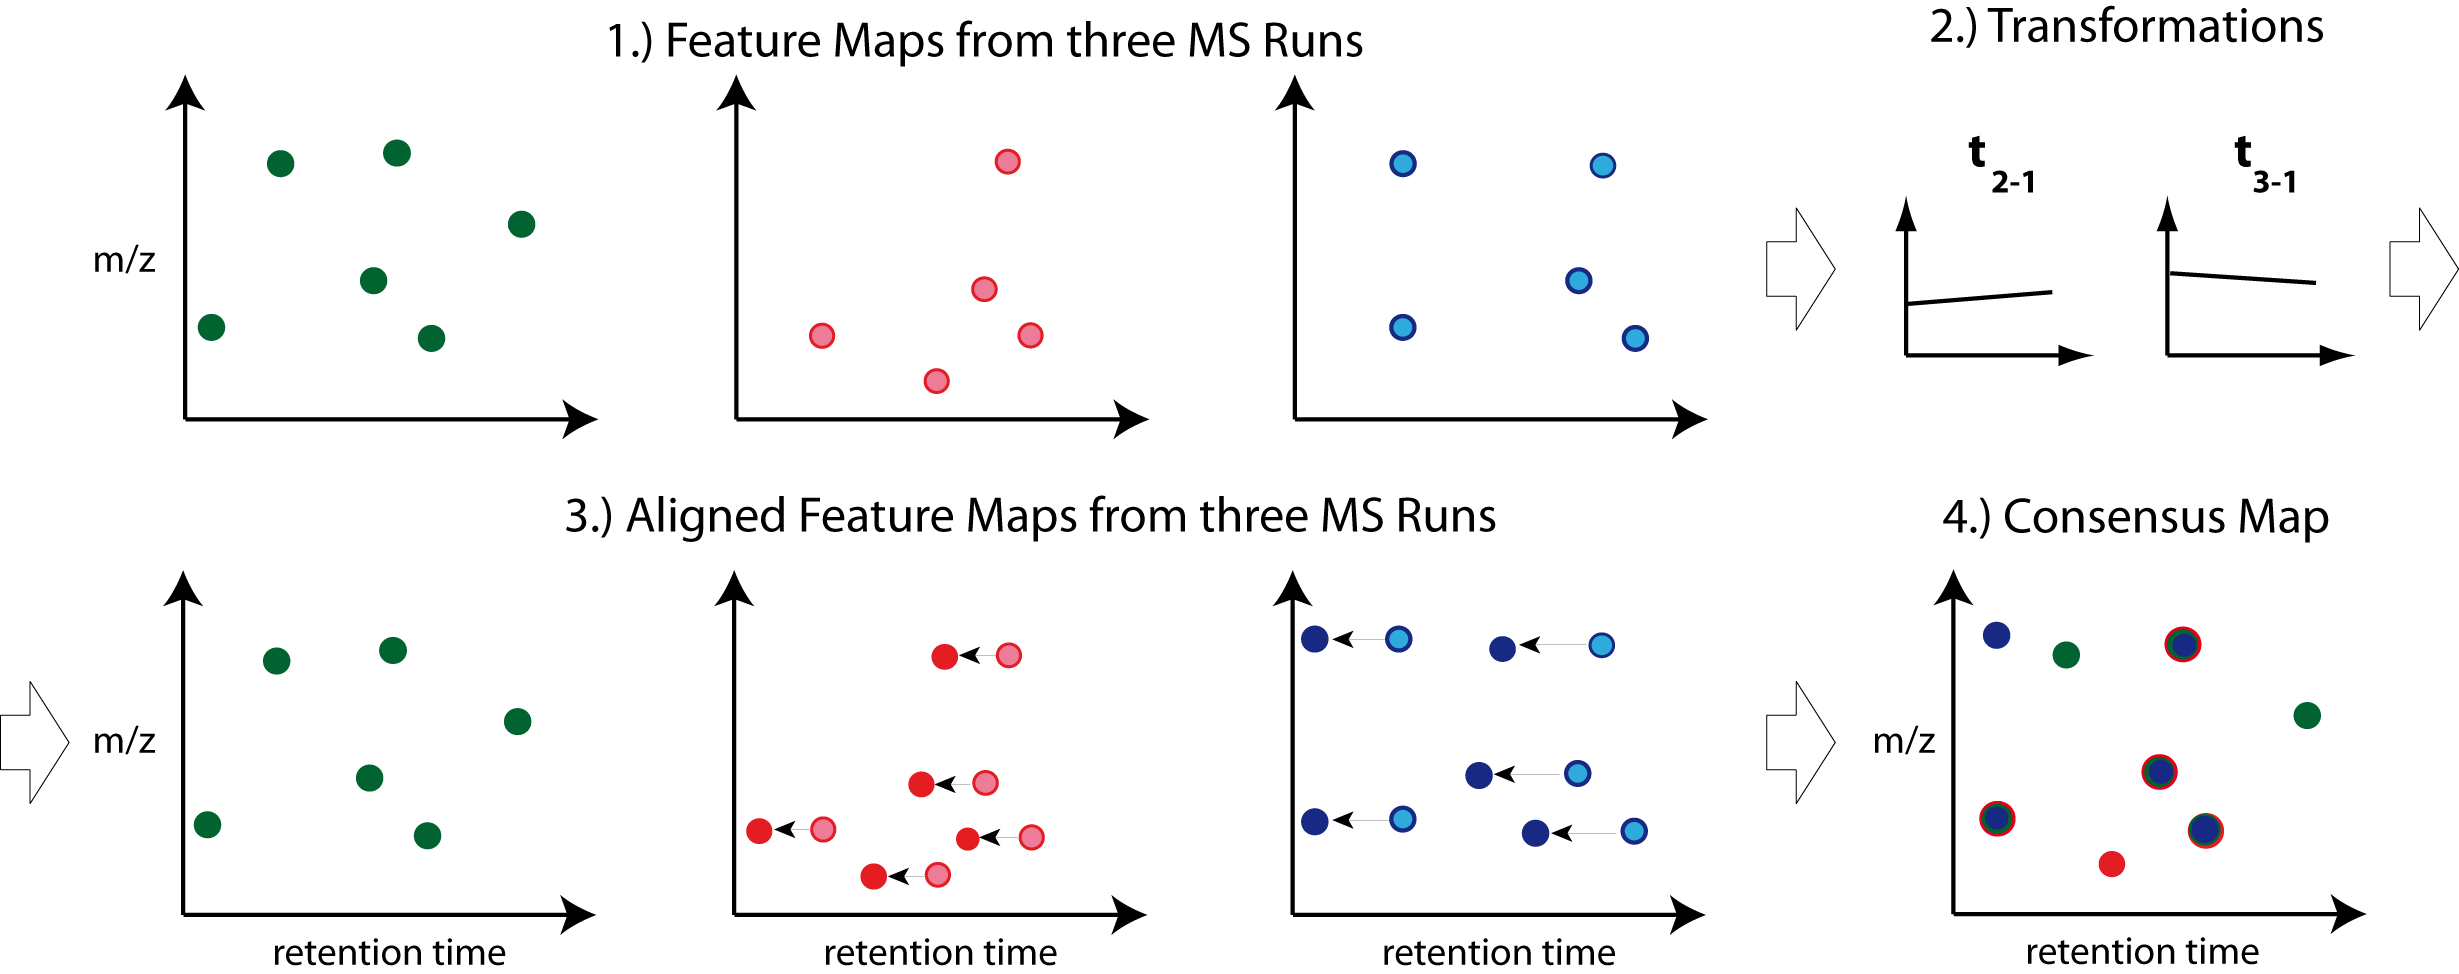

Note: Creating a
[consensus map](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-consensus-map)
from the aligned maps is performed by a [feature linking algorithm (see
next chapter)](feature_linking.ipynb).

Different map alignment algorithms are available in pyOpenMS:

-   [MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html)
-   [MapAlignmentAlgorithmIdentification](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmIdentification.html)
-   [MapAlignmentAlgorithmKD](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmKD.html)

If you want to apply a custom RT mapping, you can use:

-   [MapAlignmentTransformer](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentTransformer.html)

To perform a simple linear alignment (an affine transformation to be
exact, i.e. an offset and a slope) we can employ the algorithm
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html).
This algorithm in OpenMS can also align peak maps, but we usually
recommend aligning on the feature level, since it's much faster (less
features than peaks) and also more stable.

Other map alignment algorithms in pyOpenMS require the input data to
have
[PSMs](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-PSMs)
annotated. See [Annotating PSMs to features](PSM_to_features.ipynb) on
how to do that. Also, some require (or support) a reference map (the one
which all the other feature maps align to). More on this below. All
algorithms except
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html)
can correct the RT using a variety of models/functions fitted to the
landmarks used across feature maps.

Here is a summary table:

| algorithm                                                                                                                                                        | input type                  | transformation in RT           | uses & requires PSMs | reference map        |
|------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------|--------------------------------|----------------------|----------------------|
| [MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html) | feature maps or peak maps   | linear (affine transformation) | no                   | required             |
| [MapAlignmentAlgorithmIdentification](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmIdentification.html) | peak map, feature maps, IDs | any[1]                         | yes                  | optional             |
| [MapAlignmentAlgorithmKD](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmKD.html)                         | feature maps                | any[2]                         | yes                  | not supported/needed |

Comparison of pyOpenMS' map alignment algorithms

You should pick the algorithm which does not overfit your data and
maximizes the number of complete consensus features during a later
[feature linking](feature_linking.ipynb) stage.

## Download Example Data

[1] Valid models are "linear","b_spline","lowess" or "interpolated"

[2] Valid models are "linear","b_spline","lowess" or "interpolated"

In [ ]:
import pyopenms as oms
from urllib.request import urlretrieve

base_url = (
    "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master/src/data/"
)

# we use featureXML files which already contain PSMs (as obtained by oms.IDMapper())
# ... so we can use all aligners pyOpenMS has to offer
feature_files = [
    "BSA1_F1_idmapped.featureXML",
    "BSA2_F1_idmapped.featureXML",
    "BSA3_F1_idmapped.featureXML",
]

feature_maps = []

# download the feature files and store feature maps in list (feature_maps)
for feature_file in feature_files:
    urlretrieve(base_url + feature_file, feature_file)
    feature_map = oms.FeatureMap()
    oms.FeatureXMLFile().load(feature_file, feature_map)
    feature_maps.append(feature_map)

## Selecting a Reference Map

Some alignment algorithms in pyOpenMS require to set a reference, e.g.
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html).
For others, it is optional, e.g.,
[MapAlignmentAlgorithmIdentification](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmIdentification.html).
Finally,
[MapAlignmentAlgorithmKD](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmKD.html)
is reference-free by definition.

For
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html)
we could pick the
[feature map](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-map)
with the largest number of features as a reference, to provide the
maximum number of reference points. The retention times of the other
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps)
are aligned to this.

In [ ]:
# set ref_index to feature map index with largest number of features
ref_index = [
    i[0]
    for i in sorted(
        enumerate([fm.size() for fm in feature_maps]), key=lambda x: x[1]
    )
][-1]

aligner = oms.MapAlignmentAlgorithmPoseClustering()
aligner.setReference(feature_maps[ref_index])

## push all maps except the reference into the align method; don't align the reference to itself for max. efficiency
feature_maps_to_align = feature_maps[:ref_index] + feature_maps[ref_index+1:]

## Map Alignment Algorithm

Now, let's run an algorithm. Since the interfaces of the aligners differ
slightly, we will go though them one by one, starting with
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html).

In [ ]:
aligner = oms.MapAlignmentAlgorithmPoseClustering()
aligner.setReference(feature_maps[ref_index])


## change default params, if you want ...
p = aligner.getParameters()
# p.setValue(...)
aligner.setParameters(p)

# perform alignment and transformation of feature maps to the reference map (exclude reference map)
for feature_map in feature_maps_to_align:
    trafo = oms.TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = oms.MapAlignmentTransformer()
    transformer.transformRetentionTimes(
        feature_map, trafo, True
    )  # store original RT as meta value in `feature_map`

The interface of
[MapAlignmentAlgorithmIdentification](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmIdentification.html)
is a bit different, so have to adapt our code a bit. In contrast to
[MapAlignmentAlgorithmPoseClustering](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.MapAlignmentAlgorithmPoseClustering.html),
which always fits a linear model, we can choose which model to fit to
the landmarks found by the algorithm. Our choices are
"linear","b_spline","lowess" and "interpolated".

You can test different models, but since we only have very few data
points in our toy example, the linear model works best.

## Visualization

Plotting
[feature maps](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-feature-maps)
before and after alignment. We should observe that the data points
cluster closer together:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_consensus_maps(fmaps):
    """
    Plots consensus maps before and after alignment.

    Parameters:
    - fmaps: List of FeatureMaps.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    titles = ["consensus map before alignment", "consensus map after alignment"]
    x_labels = ["RT", "RT"]
    y_label = "m/z"

    for i, ax in enumerate(axes):
        ax.set_title(titles[i])
        ax.set_xlabel(x_labels[i])
        if i == 0: ax.set_ylabel(y_label)

        for fm in fmaps:
            x_data = [f.getMetaValue("original_RT") if i == 0 else f.getRT() for f in fm]
            y_data = [f.getMZ() for f in fm]
            alpha_values = np.asarray([f.getIntensity() for f in fm]) / max([f.getIntensity() for f in fm])
            ax.scatter(x_data, y_data, alpha=alpha_values)

    fig.tight_layout()
    fig.legend(
        [fmap.getDataProcessing()[0].getMetaValue("parameter: out")[:-11] for fmap in fmaps],
        loc="lower center",
    )
    plt.show()

# Example usage:
plot_consensus_maps(feature_maps)

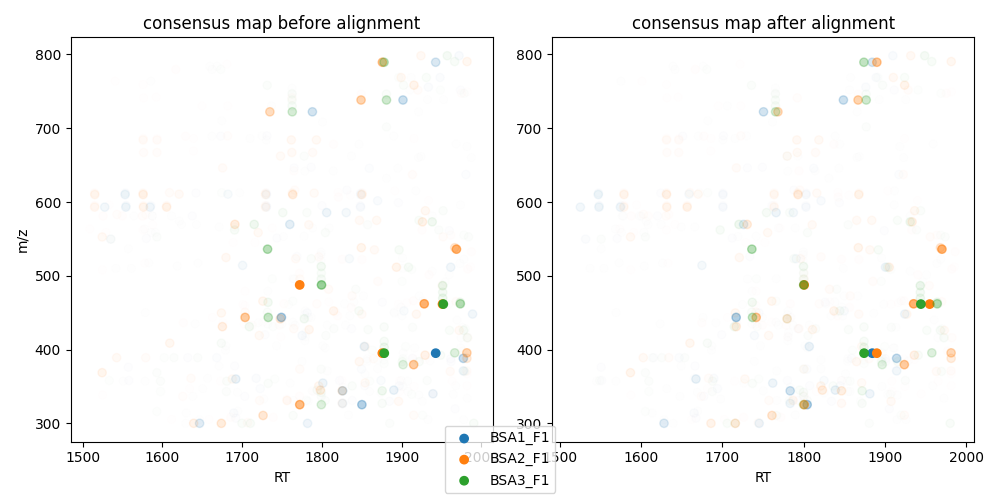

We can also inspect the underlying transformation and the landmarks it
is based upon:

While we do not know the underlying features using just this
information, we can see that features in corresponding maps are now
nicely aligned horizontally (the new RT). Also, it seems a linear model
nicely fits all the data points in each feature map. More flexible
models (e.g., LOWESS) may overfit and degrade performance—feel; free to
experiment.

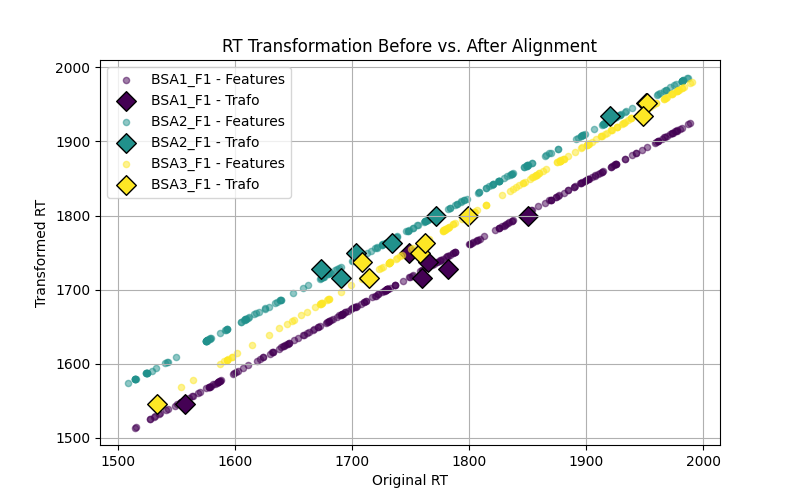